# Risk forecasting DNN model

In [1]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split

In [3]:
SERIES_PERIOD = '10y'
SERIES_INTERVAL = '1d'

LOOKBACK_WINDOW = 10
PREDICTION_LEN = 1
TRAIN_TEST_SPLIT = 0.9

EPOCHS = 50
BATCH_SIZE = 32

### Dataset

In [4]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# gather other variables
_open = sp500_history.Open[:-1]
_high = sp500_history.High[:-1]
_low = sp500_history.Low[:-1]
_volume = sp500_history.Volume[:-1]

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.mean()) / _open.std(),
    'high': (_high - _high.mean()) / _high.std(),
    'low': (_low - _low.mean()) / _low.std(),
    'volume': (_volume - _volume.mean()) / _volume.std(),

    'close': (close - close.mean()) / close.std(),
    'returns': (log_returns) / log_returns.std(),  # already centred about 0
    'volatility': (volatility - volatility.mean()) / volatility.std()
})

# remove NaN values and normalise
X.dropna(inplace=True)
X = X[list(X)].astype(np.float64)
X

,open,high,low,volume,close,returns,volatility
Date,,,,,,,
2012-06-18,-1.439822,-1.439246,-1.442920,-0.511383,-1.437988,0.134937,-0.010871
2012-06-19,-1.437069,-1.421945,-1.430984,0.099015,-1.422903,0.912962,-0.054714
2012-06-20,-1.421976,-1.424090,-1.429119,-0.032361,-1.425520,-0.157750,-0.325615
2012-06-21,-1.424958,-1.427837,-1.454488,0.405487,-1.460011,-2.104223,0.703767
2012-06-22,-1.458674,-1.451053,-1.452750,1.697850,-1.449143,0.668188,0.622966
...,...,...,...,...,...,...,...
2022-06-03,1.753706,1.733254,1.738754,-0.678663,1.720601,-1.540547,1.347387
2022-06-06,1.750451,1.762896,1.750851,0.139311,1.735333,0.292782,0.697131
2022-06-07,1.706749,1.758446,1.717483,-0.273074,1.780190,0.885903,0.768465


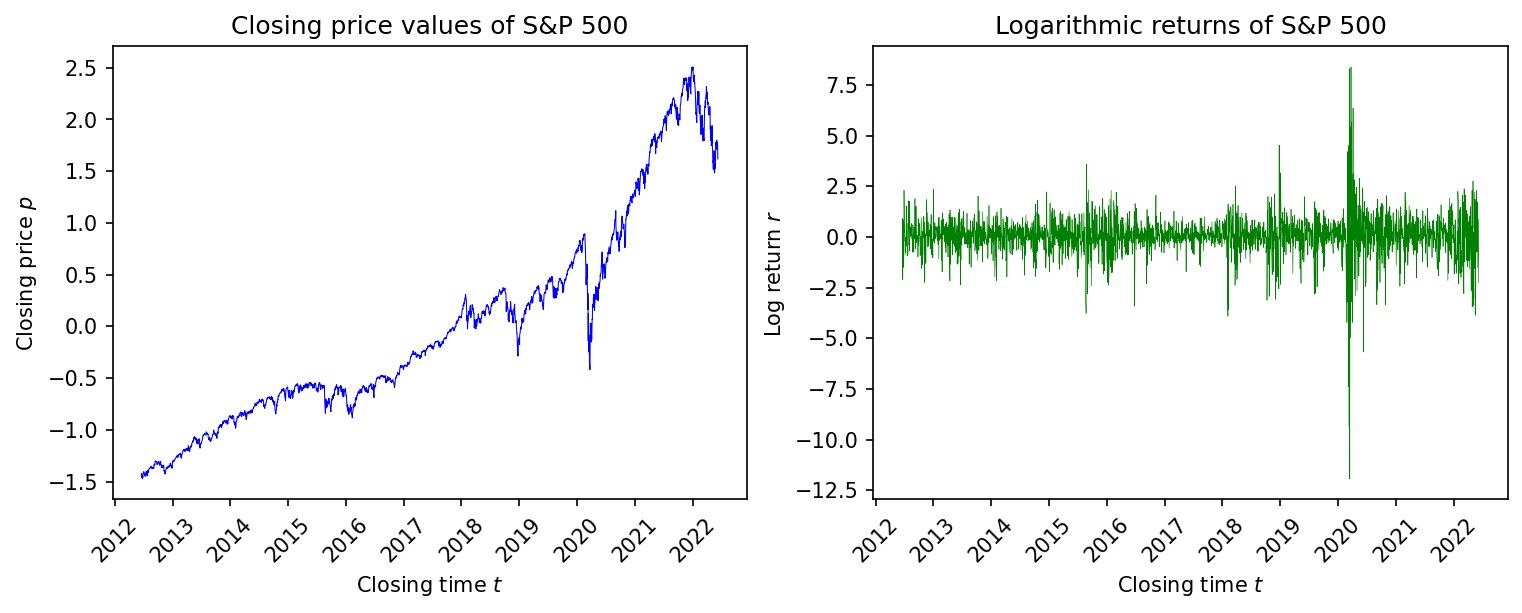

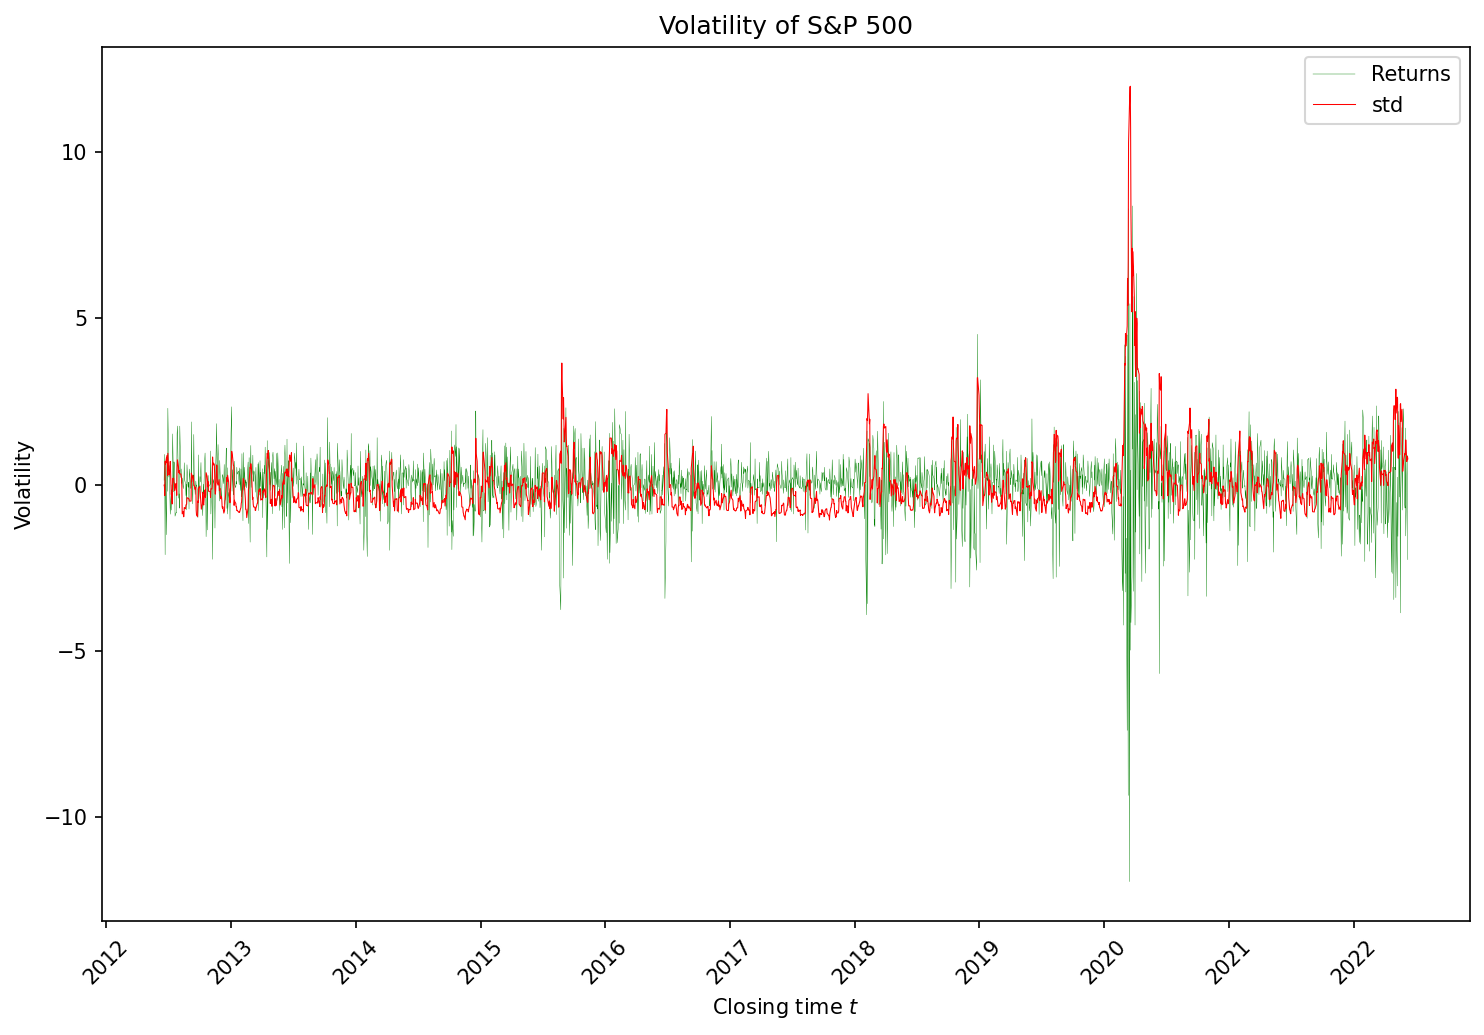

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.5, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.3, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.2, color='g', label='Returns')
ax.plot(X.volatility, linewidth=0.5, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data = []
y_data = []

for i in range(X.shape[0] - LOOKBACK_WINDOW - PREDICTION_LEN):
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + PREDICTION_LEN])

# convert X, y to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=(1 - TRAIN_TEST_SPLIT), shuffle=False)

train_test_split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:train_test_split]
y_train = y_data[:train_test_split]

X_test = X_data[train_test_split:]
y_test = y_data[train_test_split:]

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

90% training data, 10% testing data
(2250, 10, 7) (2250, 1) 
 (251, 10, 7) (251, 1)


In [7]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

# models = {
#     'rnn': rnn_model, 
#     'gru': gru_model, 
#     'lstm': lstm_model, 
#     'bidir': bidir_model
# }

models = {
    'lstm': lstm_model
}

for model in models.values():
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

In [8]:
histories = {}
for m in range(len(models)):
    model = list(models.values())[m]
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
    histories.update({list(models.keys())[m]: history.history})

Epoch 1/50
71/71 [==============================] - 4s 6ms/step - loss: 0.3350 - mse: 0.2974
Epoch 2/50
71/71 [==============================] - 0s 6ms/step - loss: 0.2429 - mse: 0.1569
Epoch 3/50
71/71 [==============================] - 0s 6ms/step - loss: 0.2101 - mse: 0.1314
Epoch 4/50
71/71 [==============================] - 0s 6ms/step - loss: 0.2038 - mse: 0.1164
Epoch 5/50
71/71 [==============================] - 0s 6ms/step - loss: 0.2035 - mse: 0.1183
Epoch 6/50
71/71 [==============================] - 0s 6ms/step - loss: 0.1954 - mse: 0.1064
Epoch 7/50
71/71 [==============================] - 0s 6ms/step - loss: 0.1892 - mse: 0.0994
Epoch 8/50
71/71 [==============================] - 0s 6ms/step - loss: 0.1910 - mse: 0.1059
Epoch 9/50
71/71 [==============================] - 0s 6ms/step - loss: 0.1928 - mse: 0.1079
Epoch 10/50
71/71 [==============================] - 0s 6ms/step - loss: 0.1881 - mse: 0.1012
Epoch 11/50
71/71 [==============================] - 0s 6ms/step - lo

In [9]:
predictions = {}
metrics = {}
for m in range(len(models.values())):
    model = list(models.values())[m]
    prediction = lstm_model.predict(X_test)

    mae = np.abs(np.subtract(y_test, prediction)).mean()
    mse = np.square(np.subtract(y_test, prediction)).mean()
    msle = np.square(np.subtract(np.log(y_test + 1), np.log(prediction + 1))).mean()
    mape = np.abs((y_test - prediction) / y_test).mean() * 100

    metrics.update({
        list(models.keys())[m]: {
            'mae': mae,
            'mse': mse,
            'msle': msle,
            'mape': mape
        }
    })

    predictions.update({
        list(models.keys())[m]: {
            'scaled': prediction,
            'unscaled': prediction * volatility.std() + volatility.mean()
        }
    })

    print(f" - {list(models.keys())[m]}: \n\t mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")


x = 2
y = len(metrics) % x

 - lstm: 
	 mae = 0.22400; mse = 0.10906; msle = 0.12606; mape = 90.02298%


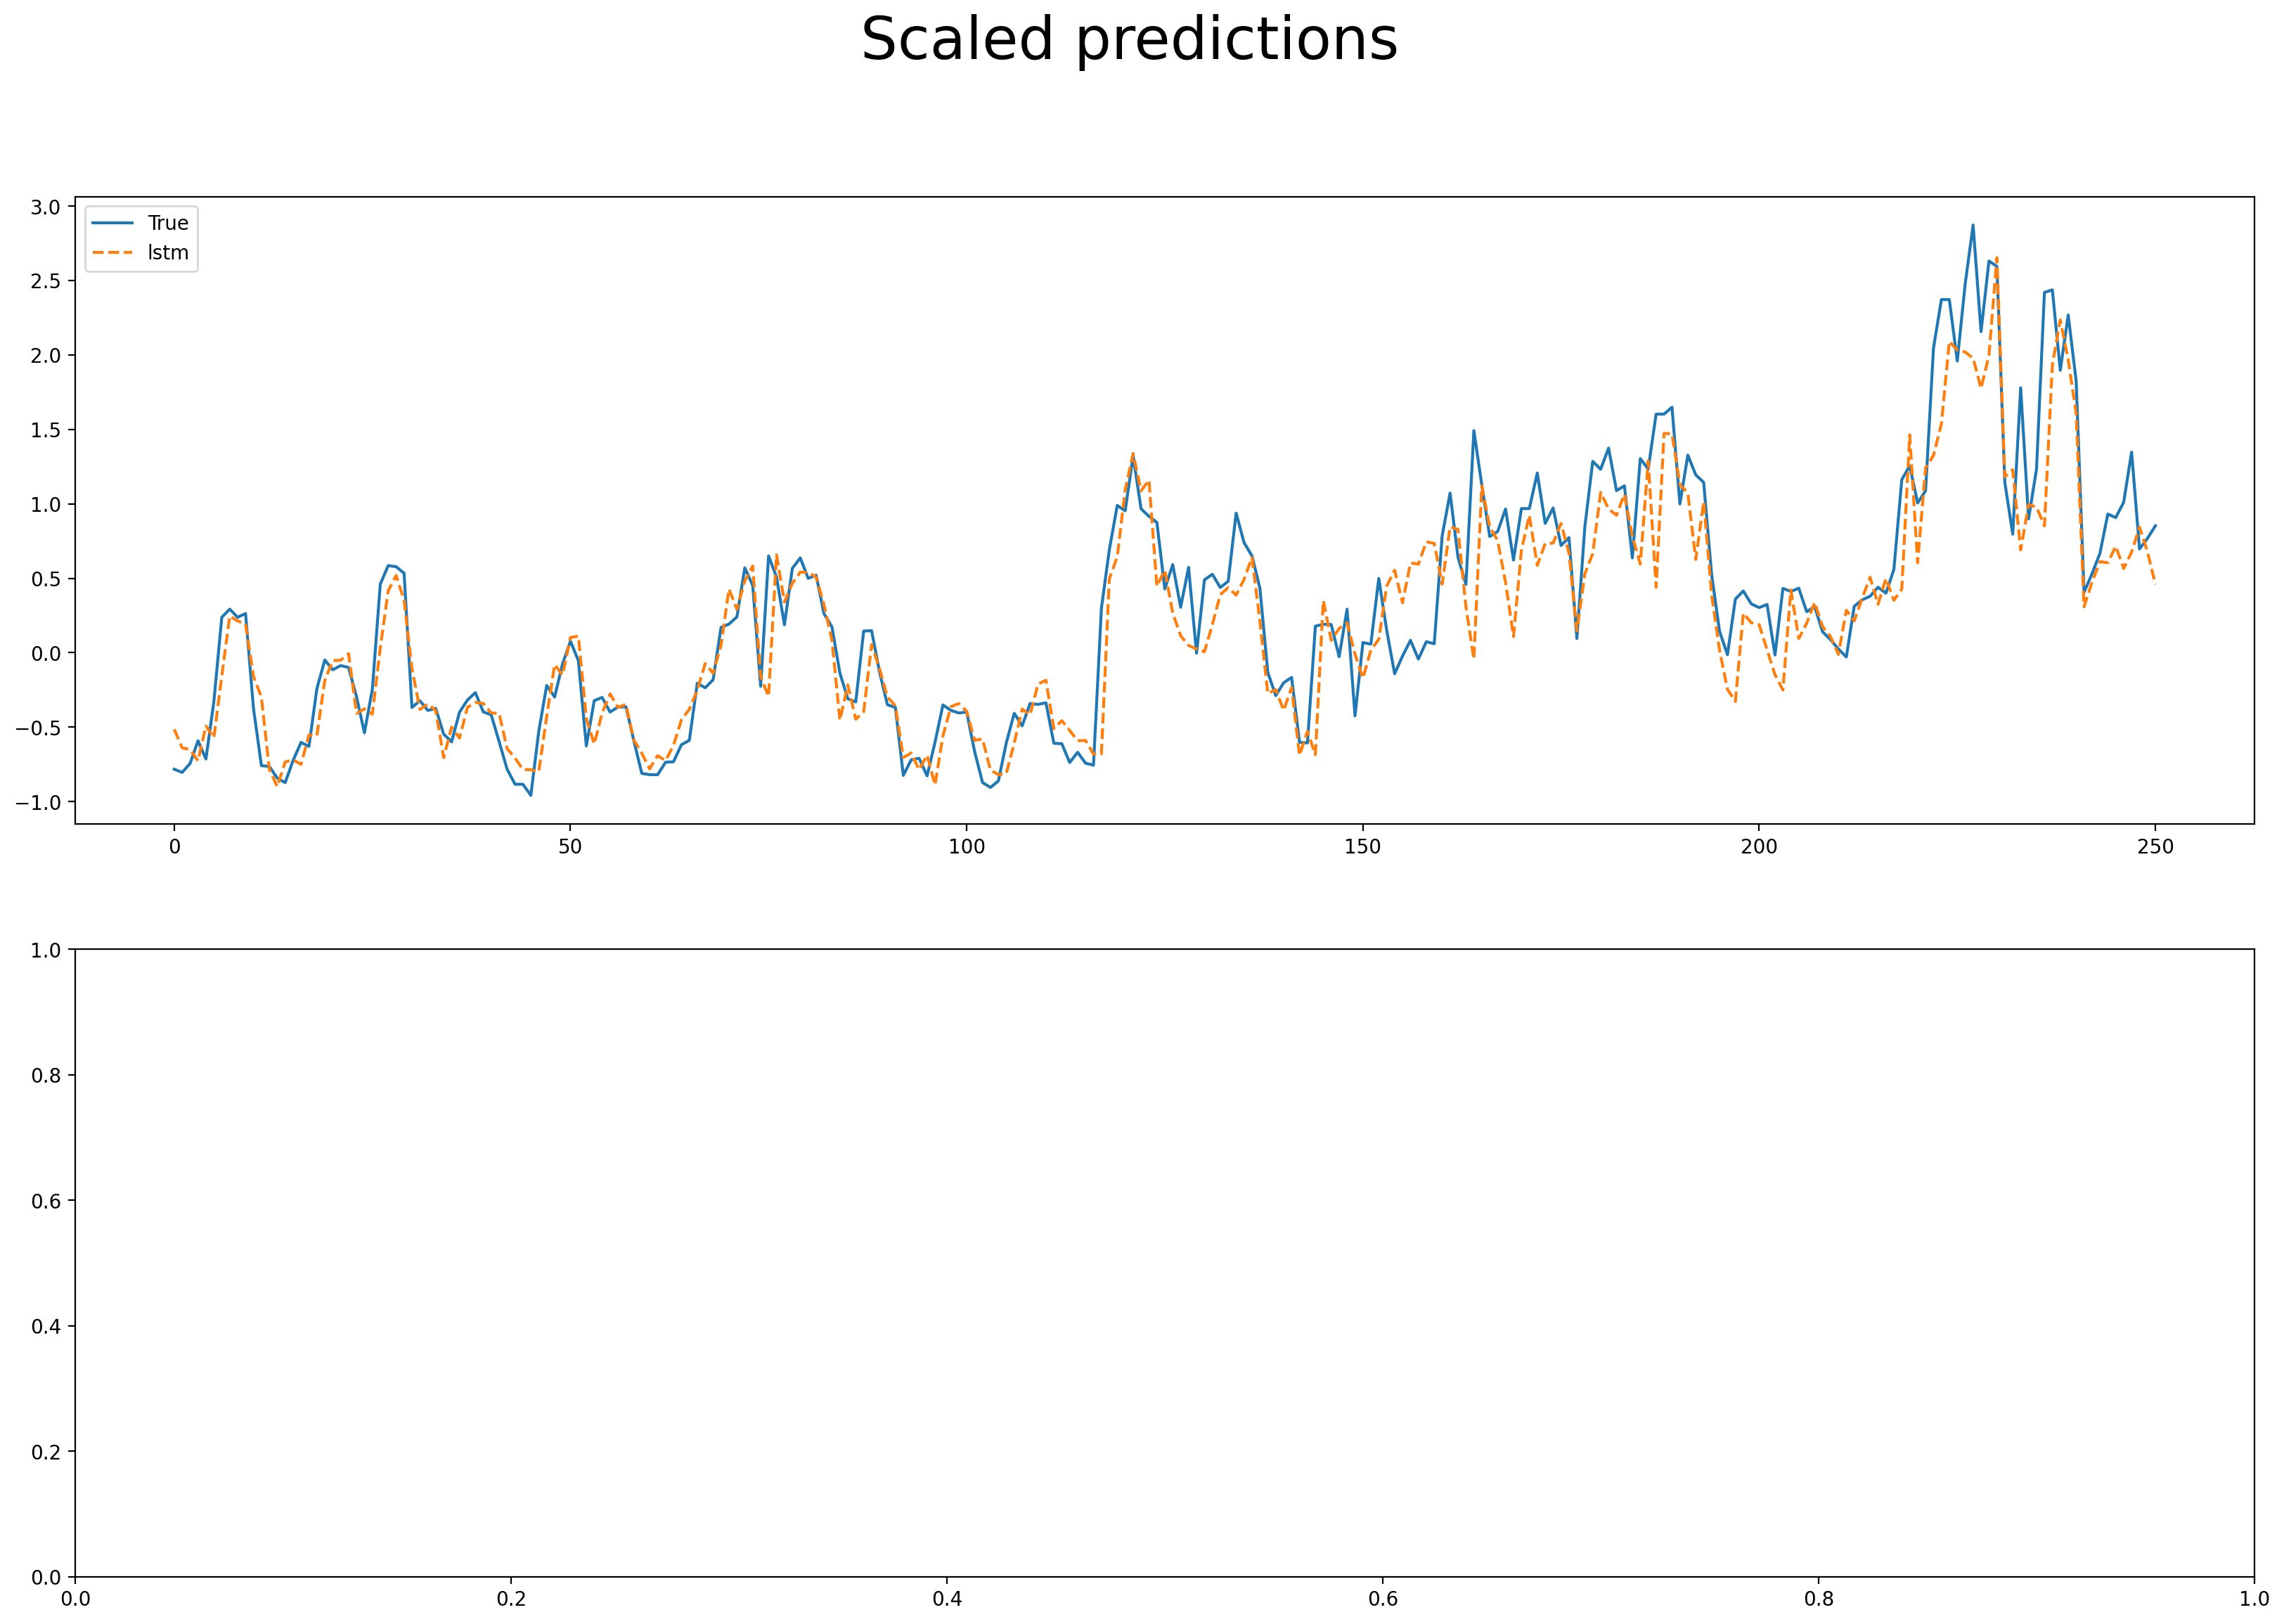

In [10]:
fig, ax = plt.subplots(x, y, figsize=(10 * x, 13*y), dpi=200)
fig.suptitle("Scaled predictions", fontsize=30)

ind = 0
if y > 1 and x > 1:
    for _y in range(y):
        for _x in range(x):
            if (_y * x + _x) < len(metrics):
                ax[_x, _y].plot(y_test, label='True')
                ax[_x, _y].plot(predictions[list(metrics.keys())[ind]]['scaled'], linestyle='--', label=list(metrics.keys())[ind])
                ax[_x, _y].legend(loc=2)
                ind += 1
else:
    for _x in range(x):
        if _x < len(metrics):
            ax[_x].plot(y_test, label='True')
            ax[_x].plot(predictions[list(metrics.keys())[_x]]['scaled'], linestyle='--', label=list(metrics.keys())[_x])
            ax[_x].legend(loc=2)

plt.show()

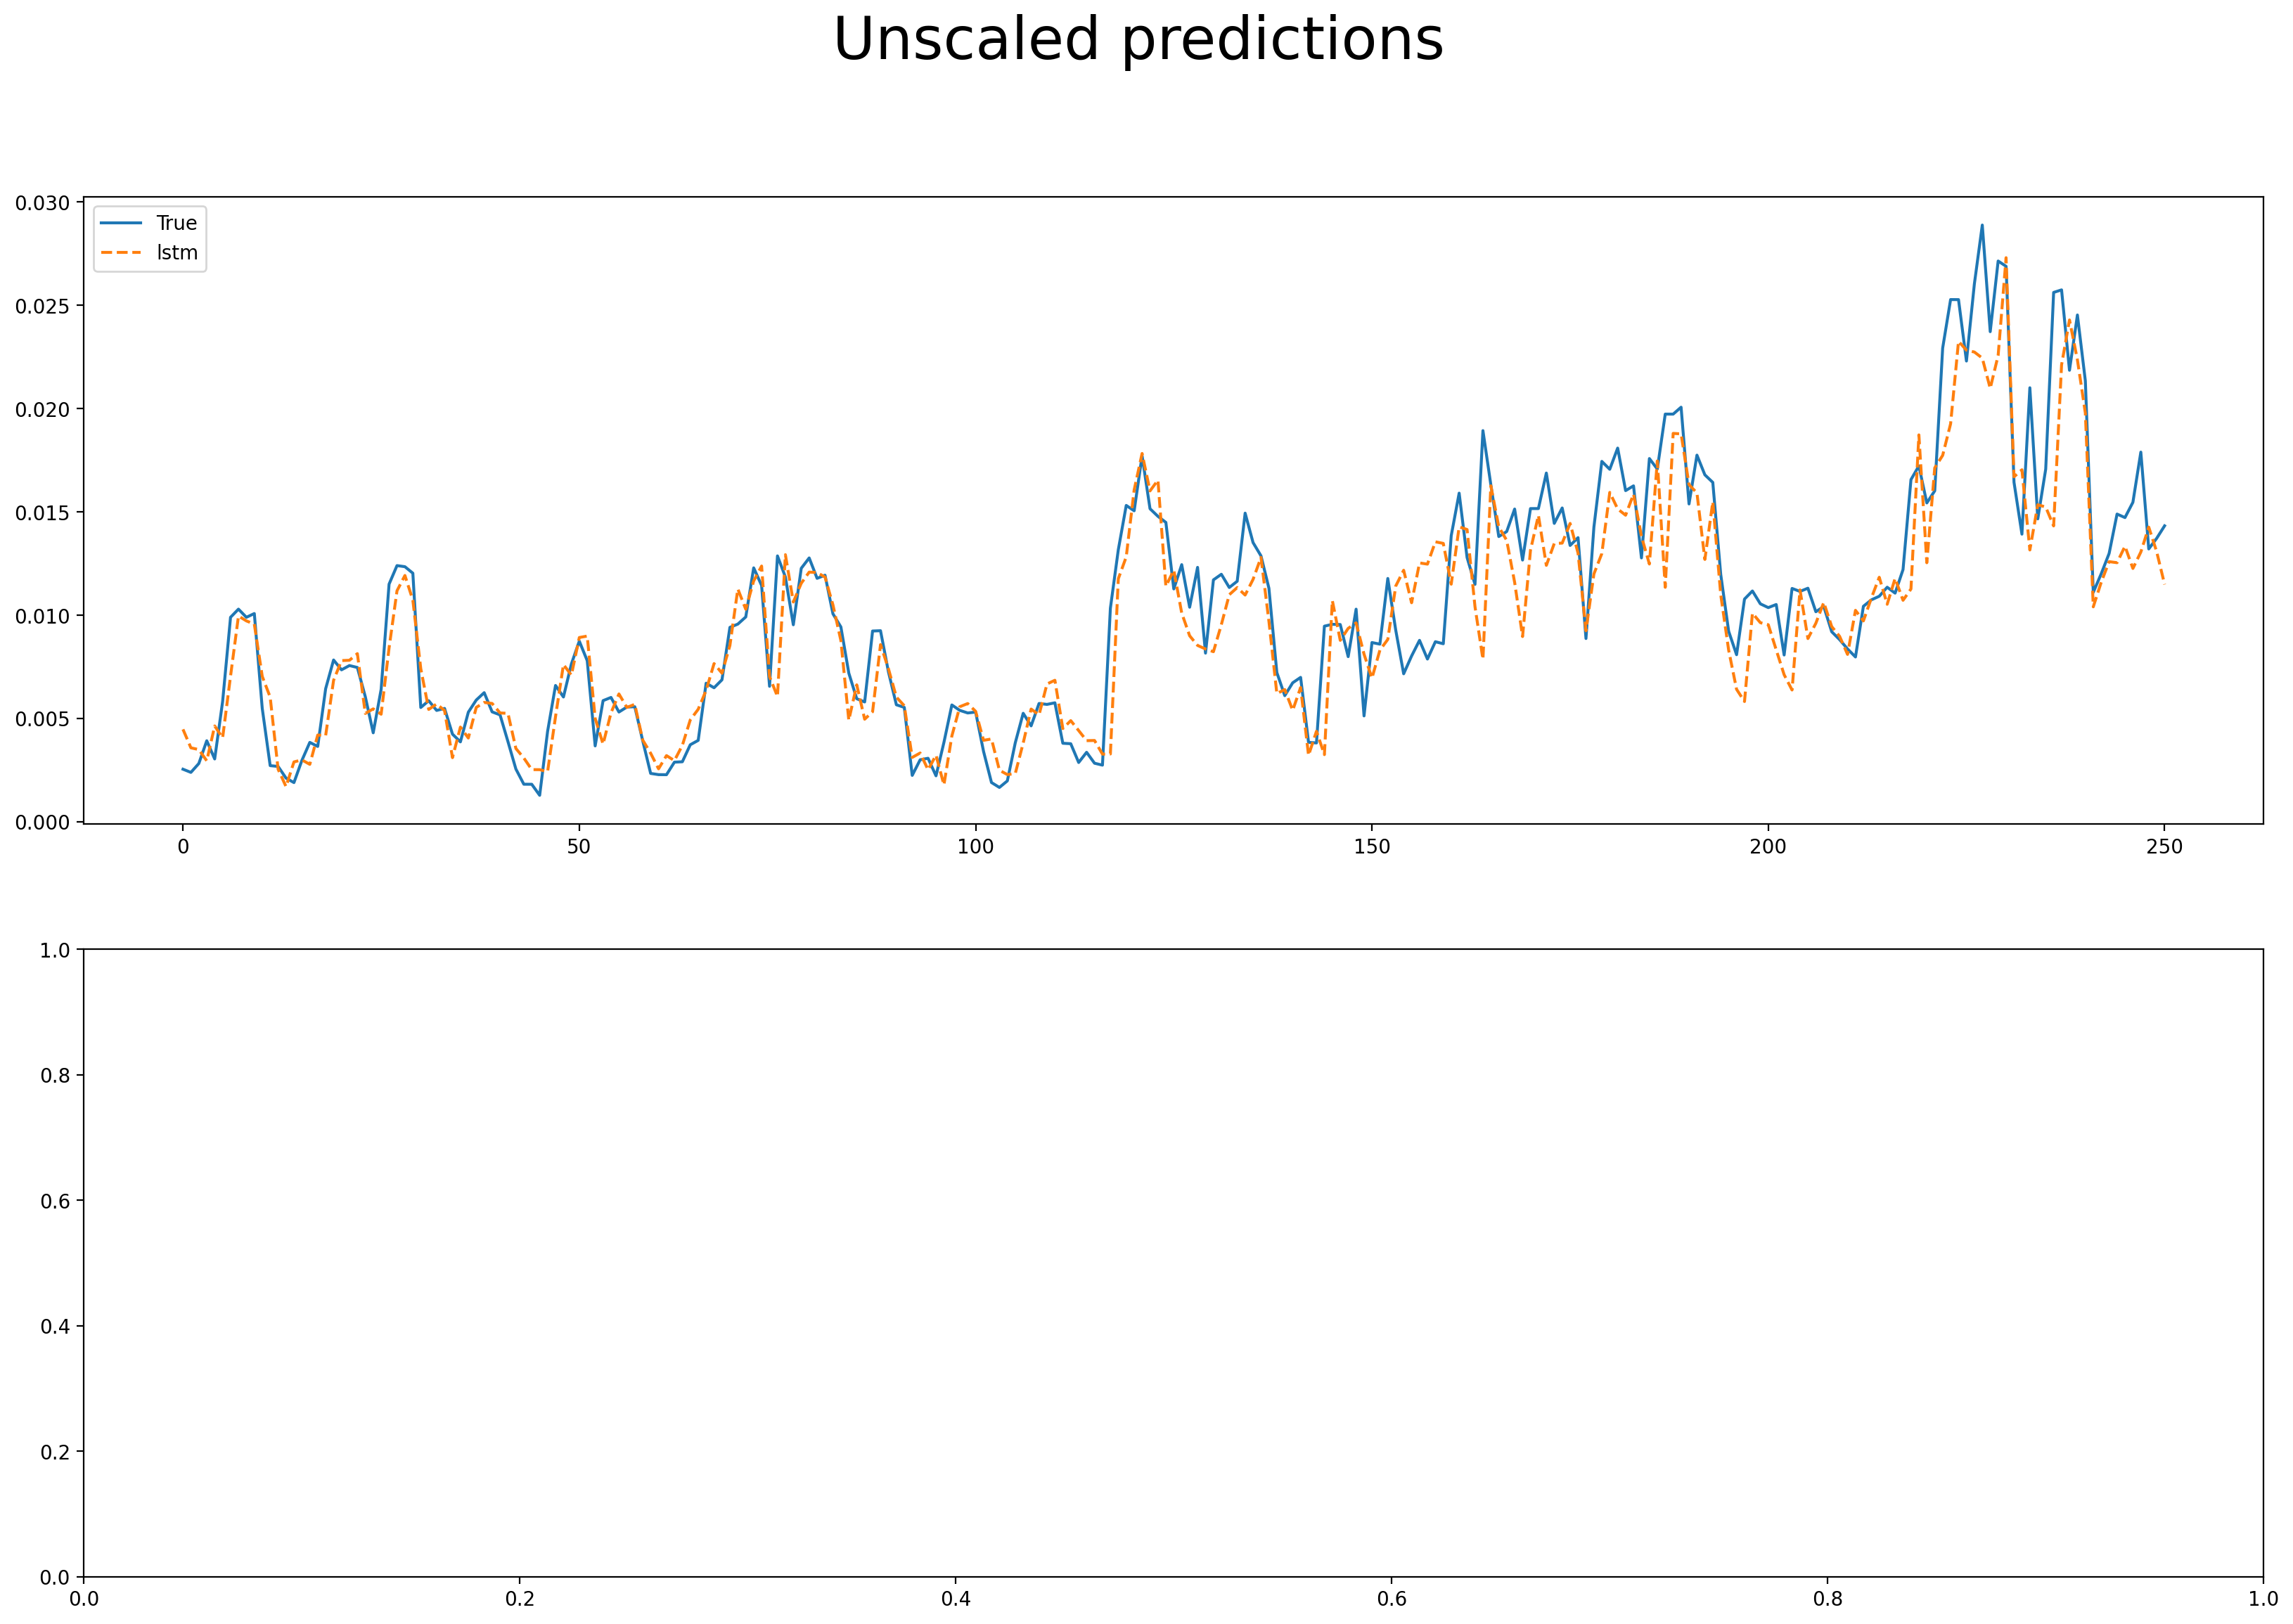

In [11]:
y_test_unscaled = y_test * volatility.std() + volatility.mean()

fig, ax = plt.subplots(x, y, figsize=(10 * x, 13*y), dpi=200)
fig.suptitle("Unscaled predictions", fontsize=30)

ind = 0
if y > 1 and x > 1:
    for _y in range(y):
        for _x in range(x):
            if (_y * x + _x) < len(metrics):
                ax[_x, _y].plot(y_test_unscaled, label='True')
                ax[_x, _y].plot(predictions[list(metrics.keys())[ind]]['unscaled'], linestyle='--', label=list(metrics.keys())[ind])
                ax[_x, _y].legend(loc=2)
                ind += 1
else:
    for _x in range(x):
        if _x < len(metrics):
            ax[_x].plot(y_test_unscaled, label='True')
            ax[_x].plot(predictions[list(metrics.keys())[_x]]['unscaled'], linestyle='--', label=list(metrics.keys())[_x])
            ax[_x].legend(loc=2)

plt.show()

### Error metrics

*Univariate:*

- RNN: 
	- mse = 0.001074650754406612; mae = 0.023033138734553867; mape = 12.91123152923138%
 - GRU: 
	- mse = 0.0007996564517214099; mae = 0.01919836468773903; mape = 10.721522533753063%
 - LSTM: 
	- mse = 0.000811033351244647; mae = 0.01918201674848624; mape = 10.663131522243265%
 - Bidirectional LSTM: 
	- mse = 0.000755576708226678; mae = 0.020408566937683045; mape = 11.719401281215514%

*Multivariate:*

 - RNN: 
	- mae = 0.02606; mse = 0.00120; msle = 0.00082; mape = 15.57855%
 - GRU: 
	- mae = 0.02097; mse = 0.00080; msle = 0.00055; mape = 12.74910%
 - LSTM: 
	- mae = 0.02211; mse = 0.00087; msle = 0.00059; mape = 12.83362%
 - Bidirectional LSTM: 
	- mae = 0.02302; mse = 0.00090; msle = 0.00062; mape = 13.66875%